# Preprocessing

## 1: Import & Load Data
Import library dan load metadata dari CSV.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
from sklearn.preprocessing import StandardScaler, LabelEncoder
import joblib
import seaborn as sns

print("✅ Libraries imported!")

# Load metadata
metadata_df = pd.read_csv("audio_metadata.csv")
print(f"📊 Loaded {len(metadata_df)} audio files")
print(metadata_df[['filename', 'split', 'class', 'duration']].head())

✅ Libraries imported!
📊 Loaded 400 audio files
                   filename  split class  duration
0   buka48k-buka_36.wav.wav  train  buka  3.764354
1  buka48k-buka_132.wav.wav  train  buka  2.429396
2  buka48k-buka_135.wav.wav  train  buka  2.174333
3  buka48k-buka_102.wav.wav  train  buka  3.034292
4   buka48k-buka_32.wav.wav  train  buka  3.764354



## 2: Visualisasi Distribusi Durasi  
Menampilkan distribusi durasi audio per kelas dan split.


📈 VISUALISASI DISTRIBUSI DURASI


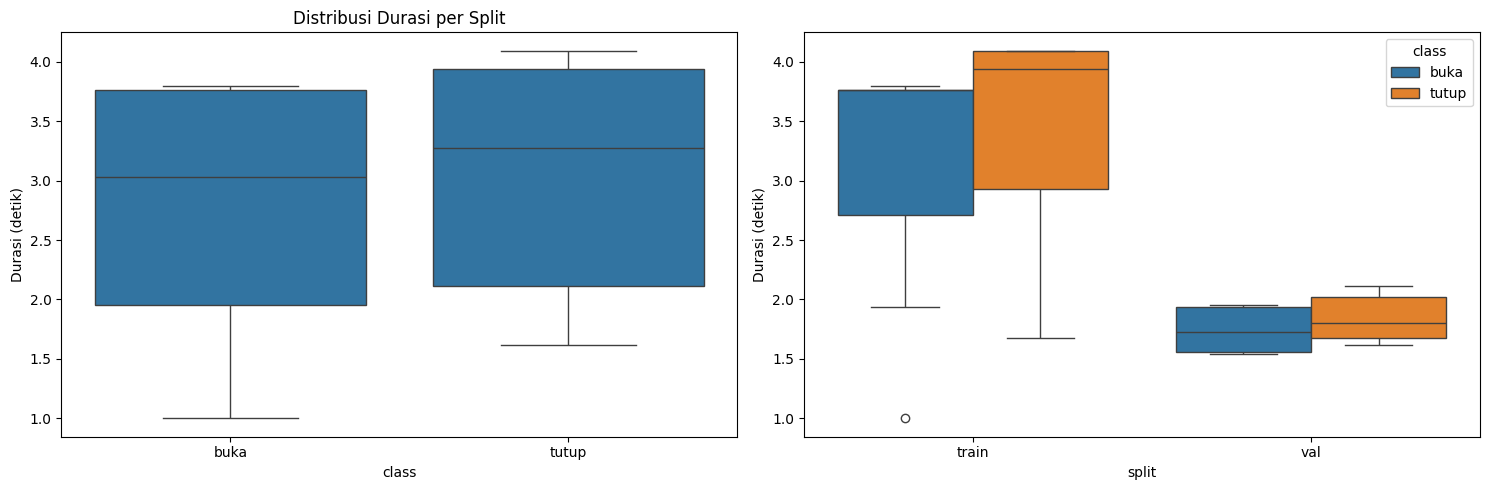


📊 STATISTIK DURASI:
       count      mean       std       min       25%       50%       75%  \
class                                                                      
buka   200.0  2.906666  0.882444  0.999375  1.949396  3.034292  3.764354   
tutup  200.0  3.090629  0.937491  1.614292  2.109313  3.279375  3.944313   

            max  
class            
buka   3.794292  
tutup  4.094333  


In [4]:
print("📈 VISUALISASI DISTRIBUSI DURASI")
print("=" * 40)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Distribusi durasi by class
sns.boxplot(data=metadata_df, x='class', y='duration', ax=ax1)
ax1.set_title('Distribusi Durasi per Kelas')
ax1.set_ylabel('Durasi (detik)')

# Distribusi durasi by split
sns.boxplot(data=metadata_df, x='split', y='duration', hue='class', ax=ax2)
ax1.set_title('Distribusi Durasi per Split')
ax2.set_ylabel('Durasi (detik)')

plt.tight_layout()
plt.show()

# Statistik durasi
print("\n📊 STATISTIK DURASI:")
print(metadata_df.groupby('class')['duration'].describe())


## 3: Extract Features
Melakukan ekstraksi fitur MFCC dari file audio.


In [5]:
def extract_features(file_path, sr=22050, n_mfcc=13):
    """Extract features dari audio file"""
    try:
        y, sr = librosa.load(file_path, sr=sr)
        
        # MFCC features
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        mfcc_mean = np.mean(mfcc, axis=1)
        mfcc_std = np.std(mfcc, axis=1)
        
        # Additional features
        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y))
        
        # Combine features
        features = np.concatenate([
            mfcc_mean,
            mfcc_std,
            [spectral_centroid, zero_crossing_rate]
        ])
        
        return features
        
    except Exception as e:
        print(f"❌ Error processing {file_path}: {e}")
        return None

print("🔧 EXTRACTING FEATURES...")
features = []
labels = []

for idx, row in metadata_df.iterrows():
    if idx % 50 == 0:
        print(f"Processed {idx}/{len(metadata_df)} files...")
    
    feature_vector = extract_features(row['file_path'])
    if feature_vector is not None:
        features.append(feature_vector)
        labels.append(row['class'])

X = np.array(features)
y = np.array(labels)

print(f"✅ Feature extraction completed: {X.shape}")

🔧 EXTRACTING FEATURES...
Processed 0/400 files...
Processed 50/400 files...
Processed 100/400 files...
Processed 150/400 files...
Processed 200/400 files...
Processed 250/400 files...
Processed 300/400 files...
Processed 350/400 files...
✅ Feature extraction completed: (400, 28)



## 5: Visualisasi Features
Menampilkan distribusi dan hubungan antar fitur.


📊 VISUALISASI FEATURES


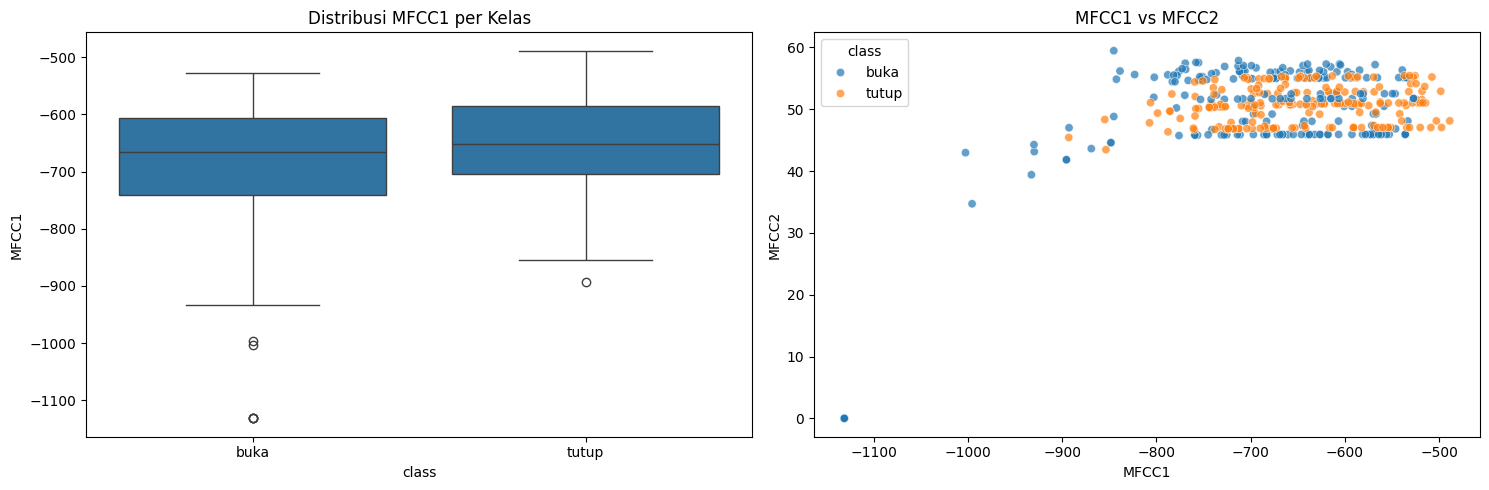

📋 Shape features: (400, 28)
🎯 Classes: ['buka' 'tutup']


In [6]:
print("📊 VISUALISASI FEATURES")
print("=" * 40)

# Create feature DataFrame untuk visualisasi
feature_df = pd.DataFrame(X[:, :5], columns=['MFCC1', 'MFCC2', 'MFCC3', 'MFCC4', 'MFCC5'])
feature_df['class'] = labels

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Distribusi MFCC1 by class
sns.boxplot(data=feature_df, x='class', y='MFCC1', ax=ax1)
ax1.set_title('Distribusi MFCC1 per Kelas')

# Scatter plot MFCC1 vs MFCC2
sns.scatterplot(data=feature_df, x='MFCC1', y='MFCC2', hue='class', ax=ax2, alpha=0.7)
ax2.set_title('MFCC1 vs MFCC2')

plt.tight_layout()
plt.show()

print(f"📋 Shape features: {X.shape}")
print(f"🎯 Classes: {np.unique(y)}")


## 5: Preprocessing & Standardization
Melakukan standardisasi fitur dan split data.


⚙️ PREPROCESSING & STANDARDIZATION
📊 Before scaling - Train mean: 14.78, std: 185.35
📊 After scaling - Train mean: 0.00, std: 1.00


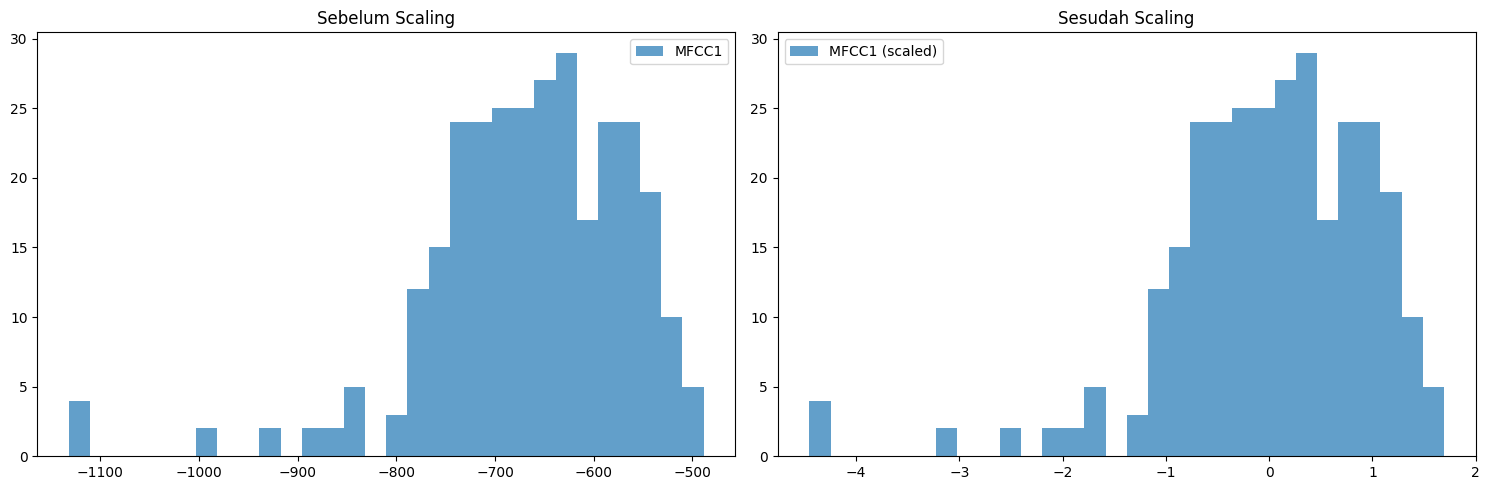

In [7]:
print("⚙️ PREPROCESSING & STANDARDIZATION")
print("=" * 40)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data berdasarkan metadata
train_mask = metadata_df.iloc[:len(X)]['split'] == 'train'
X_train = X[train_mask]
X_val = X[~train_mask]
y_train = y_encoded[train_mask]
y_val = y_encoded[~train_mask]

print(f"📊 Before scaling - Train mean: {X_train.mean():.2f}, std: {X_train.std():.2f}")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print(f"📊 After scaling - Train mean: {X_train_scaled.mean():.2f}, std: {X_train_scaled.std():.2f}")

# Visualisasi sebelum dan sesudah scaling
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Before scaling
ax1.hist(X_train[:, 0], alpha=0.7, bins=30, label='MFCC1')
ax1.set_title('Sebelum Scaling')
ax1.legend()

# After scaling
ax2.hist(X_train_scaled[:, 0], alpha=0.7, bins=30, label='MFCC1 (scaled)')
ax2.set_title('Sesudah Scaling')
ax2.legend()

plt.tight_layout()
plt.show()


## 6: Save Preprocessed Data
Menyimpan data yang sudah diproses untuk modeling.

In [8]:
print("💾 SAVING PREPROCESSED DATA")
print("=" * 40)

# Save preprocessing objects
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

# Save preprocessed data
np.save('X_train.npy', X_train_scaled)
np.save('X_val.npy', X_val_scaled)
np.save('y_train.npy', y_train)
np.save('y_val.npy', y_val)

print("✅ Preprocessed data saved:")
print(f"   ├── X_train: {X_train_scaled.shape}")
print(f"   ├── X_val: {X_val_scaled.shape}") 
print(f"   ├── y_train: {y_train.shape}")
print(f"   ├── y_val: {y_val.shape}")
print(f"   ├── scaler.pkl")
print(f"   └── label_encoder.pkl")

print(f"\n🎯 Classes mapping: {list(label_encoder.classes_)}")
print("🚀 Ready untuk modeling!")

💾 SAVING PREPROCESSED DATA
✅ Preprocessed data saved:
   ├── X_train: (300, 28)
   ├── X_val: (100, 28)
   ├── y_train: (300,)
   ├── y_val: (100,)
   ├── scaler.pkl
   └── label_encoder.pkl

🎯 Classes mapping: ['buka', 'tutup']
🚀 Ready untuk modeling!
